# Constants
Change these to fit your needs

In [67]:
# Are you developing locally or on google colab?
COLAB = True

# path kaggle will download to
HM_DATA_PATH = "/content/drive/MyDrive/dd2430/data/" if COLAB else "./data/"

# path tourch.save and .load will use
PTH_SAVE_PATH = "/content/drive/MyDrive/dd2430/pth/" if COLAB else "./pth/"

load_direct = True
if load_direct is True:
  HM_DATA_PATH, PTH_SAVE_PATH= '', '/content/'

# False if you have already downloaded once
DOWNLOAD_FROM_KAGGLE = True

# False if you have already created and saved a .pth file to PTH_SAVE_PATH
CREATE_NEW_DATASET = True

# train, test, val set size. Should sum to 1
SET_SIZES = {
    "train": 0.8,
    "test": 0.1,
    "val": 0.1,
}

# samples per class in uniform dataset
N_SAMPLES = 250

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Imports

In [ ]:
import os
import random
import numpy as np
from tqdm import tqdm
import importlib
import gdown
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import transformers
if COLAB:
    from google.colab import files, drive
    !pip install git
    #!git clone https://[ADD PERSONAL ACCESS TOKEN]@github.com/Samin765/DD2430_Project.git
    #to pull down all files
    !mv -v /content/DD2430_Project/* /content/


In [64]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available(): # For apple silicon
    device = 'mps'

print("Using device: ", device)

Using device:  cuda


# Download data

In [ ]:
if DOWNLOAD_FROM_KAGGLE:
    !pip install kaggle
    files.upload()

    os.makedirs('/root/.kaggle', exist_ok=True)
    !cp kaggle.json /root/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json

    %cd HM_DATA_PATH

    !kaggle competitions download -c h-and-m-personalized-fashion-recommendations


In [20]:
if DOWNLOAD_FROM_KAGGLE:
    !unzip -q h-and-m-personalized-fashion-recommendations.zip

#Dataset

## Create new dataset
This will create a new dataset and save it as a .pth to google drive. If you getan error, then it is most likely becuase you can not make a daatset that large.

In [ ]:
import datasets
importlib.reload(datasets)

if CREATE_NEW_DATASET:
    dataset = datasets.HMDataset2(
        articles_csv = HM_DATA_PATH + 'articles.csv',
        image_dir = HM_DATA_PATH + 'images',
        main_class = 'garment_group_name',
        model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device),
        processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    )
    # data per class
    n_samples =  N_SAMPLES

    assert dataset.articles[dataset.main_class].value_counts().min()>n_samples, 'Can not make balanced set'

    # you can also set all to n_samples then set the ones you want to 0
    for exclude_subclass in ['Unknown', 'Special Offers', 'some other']:
        dataset.counts[exclude_subclass]=n_samples

    # Create uniform dataset
    image_emb, labels, images = dataset.get_n_of_each(n_samples)

    data_to_save = {
        'image_embedding': image_emb,
        'class_text': labels,
        'images': images,
    }
    os.makedirs(PTH_SAVE_PATH, exist_ok=True)
    torch.save(data_to_save, f'{PTH_SAVE_PATH}HM_data_{n_samples}.pth')

In [46]:
def save_to_drive(data, n_samples):
    """Save the dataset you created to drive"""
    from google.colab import drive
    drive.mount('/content/drive')
    torch.save(data, f'/content/drive/My Drive/Skola/HM_data_{n_samples}.pth')
save_to_drive(data_to_save, N_SAMPLES)

Mounted at /content/drive


## Load dataset
If you already have the HM data and .pth saved in google drive, this is where the actual code/program begins.

Remember to change the constants at the top so you don't download and/or create a new dataset next time.

In [ ]:
def load_from_private_drive():
    """If you have it locally"""
    #drive.mount('/content/drive')
    n_samples = N_SAMPLES
    file_to_load = f"HM_data_{n_samples}.pth"

    loaded_data = torch.load(f'{PTH_SAVE_PATH}{file_to_load}')

    image_emb = loaded_data['image_embedding']
    labels = loaded_data['class_text']
    images = loaded_data['images']

    #dataset = UniformHMDataset(image_emb, labels , images)
    return image_emb, images, labels

def load_from_project_drive(link):
    """Shared file in drive and insert link id"""
    import gdown
    output = 'Dataset_loaded.pth'
    gdown.download(f"https://drive.google.com/uc?id={link}", output, quiet=False)
    loaded_data = torch.load(output, map_location=device)
    image_emb = loaded_data['image_embedding']
    labels = loaded_data['class_text']
    images = loaded_data['images'] # good to have to see sclaling and transform..
    #dataset = UniformHMDataset(image_emb, labels , images)
    return image_emb, images, labels

project_drive = False # if you want to load from my drive, NEW SET
if project_drive:# DO NOT USE TOO OFTEN OR 24h waiting period
  data = load_from_project_drive(link='16we5aQ_Mbk1791_8WT522HmR0lwlwwqQ')
else:
  data = load_from_private_drive()
image_emb0, images0, labels0 = data

# Evaluate

**Finetuning**

Performance decreases if we add untuned soft prompts, now we finetune

In [79]:
# functions for clip text and image embeddings, forward pass etc
# remember to import this again if you change something
# And varius function that doesn't fit into model_functions or datasets
# for example displaying images
import model_functions, utils, training, datasets
importlib.reload(utils) # issues with colab not updating
importlib.reload(training)
importlib.reload(model_functions)
importlib.reload(datasets)
import model_functions, utils, training

**Split datasets**

In [55]:
dataset, dataset_train, dataset_test, dataset_val = datasets.split(labels0, image_emb0, images0, N_SAMPLES, SET_SIZES)
batch_size = 128
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

4750 3800 475 475
Counter({'Accessories': 250, 'Blouses': 250, 'Dressed': 250, 'Dresses Ladies': 250, 'Dresses/Skirts girls': 250, 'Jersey Basic': 250, 'Jersey Fancy': 250, 'Knitwear': 250, 'Outdoor': 250, 'Shirts': 250, 'Shoes': 250, 'Shorts': 250, 'Skirts': 250, 'Socks and Tights': 250, 'Swimwear': 250, 'Trousers': 250, 'Trousers Denim': 250, 'Under-, Nightwear': 250, 'Woven/Jersey/Knitted mix Baby': 250})
Counter({'Shorts': 200, 'Knitwear': 200, 'Socks and Tights': 200, 'Under-, Nightwear': 200, 'Jersey Basic': 200, 'Accessories': 200, 'Shoes': 200, 'Trousers': 200, 'Dresses/Skirts girls': 200, 'Shirts': 200, 'Swimwear': 200, 'Skirts': 200, 'Blouses': 200, 'Outdoor': 200, 'Trousers Denim': 200, 'Woven/Jersey/Knitted mix Baby': 200, 'Jersey Fancy': 200, 'Dressed': 200, 'Dresses Ladies': 200})
Counter({'Knitwear': 25, 'Woven/Jersey/Knitted mix Baby': 25, 'Jersey Basic': 25, 'Swimwear': 25, 'Shirts': 25, 'Blouses': 25, 'Dresses/Skirts girls': 25, 'Shorts': 25, 'Dresses Ladies': 25, 'Dr

In [56]:
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.feature_extractor.do_rescale = False # make sure image values: False=> [0-1] and True=> [0,255]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


##**Baseline**

The performance of the untuned CLIP

100%|██████████| 4/4 [00:00<00:00, 54.21it/s]


Accuracy 35.157894134521484


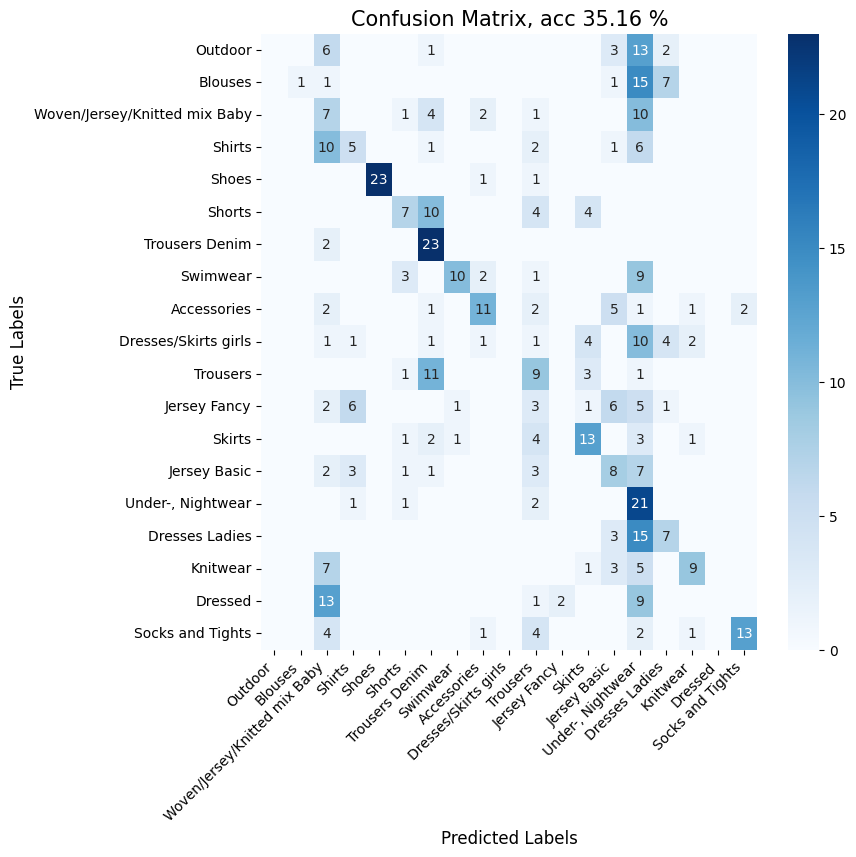

Accuracy of baseline is 35.16 %


In [57]:
dataloaders = {'train':dataloader_train, 'val':dataloader_val, 'test':dataloader_test}
clip = {'m':model, 'p':processor}

ft = training.FinetuneCLIP(dataloaders, clip)
ft.tt['soft'], ft.tt['LoRA'] = 0, 0 #baseline

ft.initialize({'add':''})  # do not add anything
all_predictions, all_labels, acc = ft.eval(False)
utils.confussion_matrix(all_labels, all_predictions, list(dataset_test.class_to_id.keys()),F1=False)
print(f"Accuracy of baseline is {acc:.2f} %")

Predicts many as Under-nightwear

##**Hard prompt tuning**

Easiest way to finetune, just change the text accompanied by labels

In [80]:
dataloaders = {'train':dataloader_train, 'val':dataloader_val, 'test':dataloader_test}
clip = {'m':model, 'p':processor}

texts = ['', 'An image of', 'The cloathing type is', 'An image showing cloathing of type']
perf = []
for added_text in texts:
    ft = training.FinetuneCLIP(dataloaders, clip)
    ft.tt['soft'], ft.tt['LoRA'] = 0, 0 #baseline
    ft.train_p['add'] = added_text
    _, _, acc = ft.eval(False)
    perf.append(np.round(acc,2))
print(perf)
print(f"Best accuracy of hard-prompt tune is {max(perf):.2f} %")

100%|██████████| 4/4 [00:00<00:00, 56.94it/s]


Accuracy 35.157894134521484


100%|██████████| 4/4 [00:00<00:00, 57.85it/s]


Accuracy 40.6315803527832


100%|██████████| 4/4 [00:00<00:00, 60.51it/s]


Accuracy 34.73684310913086


100%|██████████| 4/4 [00:00<00:00, 61.15it/s]

Accuracy 36.0
[35.16, 40.63, 34.74, 36.0]
Best accuracy of hard-prompt tune is 40.63 %


##**Soft prompt**

Add a tunable tensor in the embedding of the text. Added hyperparam search

In [ ]:
dataloaders = {'train':dataloader_train, 'val':dataloader_val, 'test':dataloader_test}
clip = {'m':model, 'p':processor}
hp ={'hyperp':[1,2,3,4,5,6] , 'best_losses':[], 'params':[]}
for num_soft in hp['hyperp']:
  ft = training.FinetuneCLIP(dataloaders, clip)
  ft.initialize({'num_soft':num_soft, 'add':''})
  ft.tt['soft'], ft.tt['LoRA'] = 1, 0 #soft
  _, train_p = ft.train()
  hp['params'].append(train_p['soft']) # TODO load best of these later to evaluate on test set, I did not, i ran it again for [5].
  hp['best_losses'].append(ft.loss['val'][-ft.es['pat']])

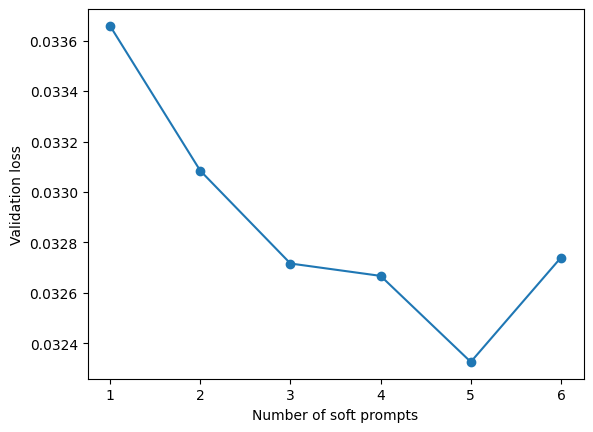

In [75]:
plt.plot(hp['hyperp'], hp['best_losses'], marker='o', linestyle='-')
plt.xlabel('Number of soft prompts')
plt.ylabel('Validation loss')
plt.show()

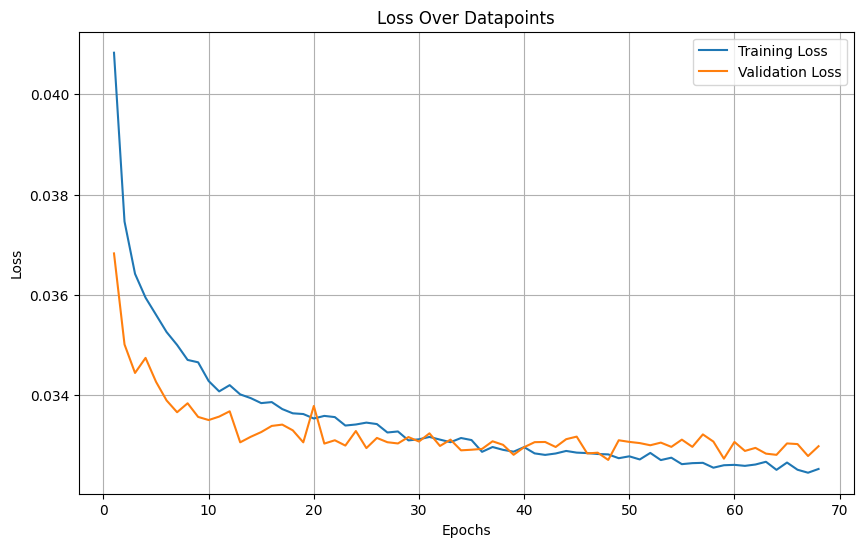

100%|██████████| 4/4 [00:00<00:00, 54.32it/s]


Accuracy 67.78947448730469


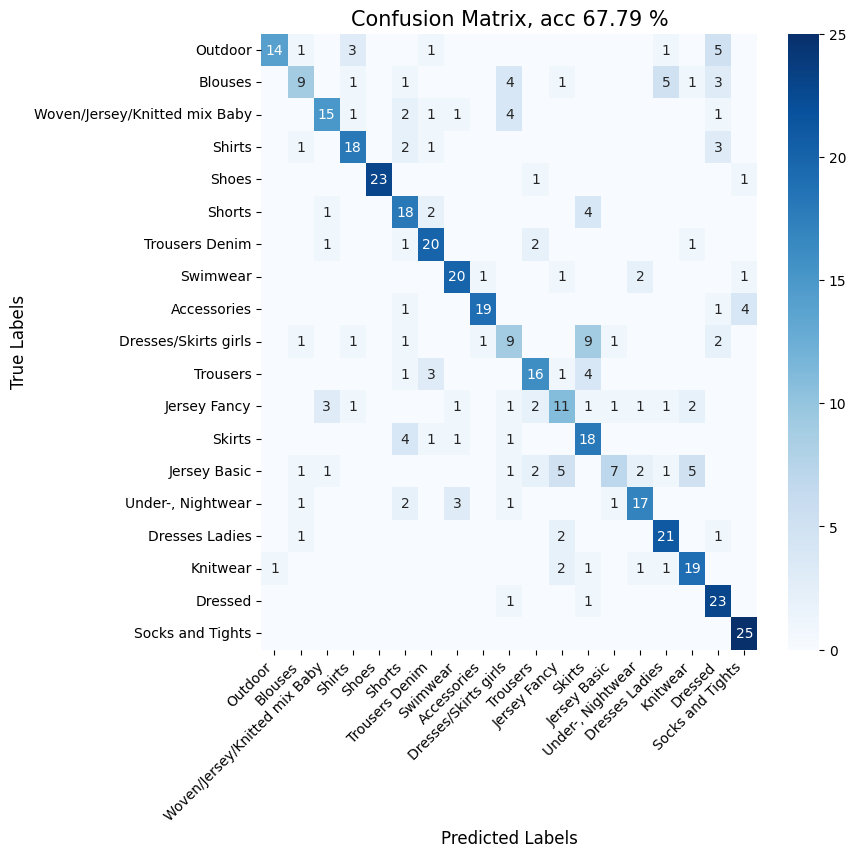

Accuracy of soft prompt is 67.79 %


In [86]:
ft.plot_loss()
#utils.print_images(dataloader_train, processor,3)
all_predictions, all_labels, acc = ft.eval(False)
utils.confussion_matrix(all_labels, all_predictions, list(dataset_test.class_to_id.keys()),F1=False)
print(f"Accuracy of soft prompt is {acc:.2f} %")

##**LoRA**

In [61]:
dataloaders = {'train':dataloader_train, 'val':dataloader_val, 'test':dataloader_test}
clip = {'m':model, 'p':processor}

ft = training.FinetuneCLIP(dataloaders, clip)
#ft.initialize({'num_soft':3, 'add':''}) #add rank here

ft.tt['soft'], ft.tt['LoRA'] = 0, 1 #LoRA
#loss, train_p = ft.train() # Fix initialization and forward

In [ ]:
ft.load_p() # get best parameters
ft.plot_loss()
#print_images(dataset_test,2, dataloader_train)
all_predictions, all_labels, acc = ft.eval(True)
utils.confussion_matrix(all_labels, all_predictions, list(dataset_test.class_to_id.keys()),F1=False)


##**Dag anything**

In [ ]:
dataloaders = {'train':dataloader_train, 'val':dataloader_val, 'test':dataloader_test}
clip = {'m':model, 'p':processor}

ft = training.FinetuneCLIP(dataloaders, clip)
